In [50]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import numpy as np

#  Defining Message functions


Message Functions:

- copy_src(src, out) : Builtin message function that computes message using source node feature.
- copy_edge(edge, out) : Builtin message function that computes message using edge feature.
- src_mul_edge(src, edge, out) : Builtin message function that computes message by multiplying source node  features with edge features.

Reduce Function:

- sum(msg, out) : Builtin reduce function that aggregates messages by sum.
- max(msg, out) : Builtin reduce function that aggregates messages by max.


In [51]:
# We first define the message and reduce function as usual.
# Since the aggregation on a node u only involves summing over the neighbors’
# representations hv, we can simply use builtin functions:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [52]:
print(gcn_msg)
print(gcn_reduce)

# Defining the Model





We now define the node function for apply_nodes, which is a fully-connected layer 

In [53]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_features, out_features, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

Define the GCN module
 
- DGLGraph.apply_nodes([func, v, inplace]) : Apply the function on the nodes to update their features.

- DGLGraph.apply_edges([func, edges, inplace]) : Apply the function on the edges to update their features.

- DGLGraph.update_all([message_func, …]) :Send messages through all edges and update all nodes.

In [54]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, activation):
        super(GCN, self).__init__()
        
        #A GCN layer essentially performs message passing on 
        #all the nodes then applies the NodeApplyModule (Defined above).
        self.apply_mod = NodeApplyModule(in_features, out_features, activation) 

    def forward(self, g, feature):
        g.ndata['h'] = feature
        
        # We use update_all and apply_nodes Send messages through all edges and update all nodes
        # and to apply the function on the nodes to update their features
        
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        
        return g.ndata.pop('h') # returns the updated features

In [449]:
input_size = 1433
hidden1 = 32
hidden2 = 16
output_size =7

Defining a deeper GCN model that contains two GCN layer 

In [540]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(input_size, hidden1, F.relu)
        self.gcn2 = GCN(hidden1, hidden2, F.relu)
        self.gcn_drop = nn.Dropout(0.3)
        self.gcn3 = GCN(hidden2, output_size, F.relu)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        x = F.dropout(x, training=self.training)
        x = self.gcn3(g, x)
        return x


In [481]:
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=32, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (gcn_drop): Dropout(p=0.3)
  (gcn3): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


# Load and Understand the data 

In [452]:
from dgl.data import citation_graph as citegrh
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = DGLGraph(data.graph)
    # add self loop
    g.remove_edges_from(g.selfloop_edges())
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask

## Load the data

In [57]:
from dgl.data import citation_graph as citegrh

In [58]:
graph_data = citegrh.load_cora()
print(graph_data)

In [12]:
graph_data.nodes # Beacuse its not in the form of graph yet

AttributeError: 'CoraDataset' object has no attribute 'nodes'

## Reading Graph form the loaded data

In [59]:
graph = DGLGraph(graph_data.graph)

In [60]:
print("The graph has 2708 nodes and 10556 edges \n")
graph 

The graph has 2708 nodes and 10556 edges 



DGLGraph(num_nodes=2708, num_edges=10556,
         ndata_schemes={}
         edata_schemes={})

In [61]:
graph.ndata

{}

## Reading features form the loaded data

In [63]:
g_1 = DGLGraph(graph_data.graph)

In [291]:
graph_features = th.FloatTensor(graph_data.features)

In [18]:
print(graph_features)
print("\nThe graph has 1433 features for every 2708 node\n")
print(graph_features.shape) # The graph has 2708 features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

The graph has 1433 features for every 2708 node

torch.Size([2708, 1433])


In [287]:
graph_features.unique()

tensor([0.0435, 0.0000, 0.1000, 0.0500, 0.0526, 0.0588, 0.0909, 0.0455, 0.0476,
        0.0385, 0.0769, 0.2000, 0.1111, 0.0556, 0.1429, 0.1667, 0.3333, 0.0333,
        0.0667, 0.1250, 0.2500, 0.0625, 0.0400, 0.0833, 0.0417, 0.5000, 1.0000,
        0.0357, 0.0714, 0.0370])

In [288]:
graph_features.shape

torch.Size([2708, 1433])

In [290]:
graph_features[1].shape

torch.Size([1433])

### TNSE used for visualization

In [337]:
from sklearn.manifold import TSNE

In [402]:
transform = TSNE
trans = transform(n_components=2)

In [341]:
node_embeddings_2d = trans.fit_transform(graph_features)

In [342]:
node_embeddings_2d

array([[-34.324886 , -33.008987 ],
       [ 24.075119 ,  27.828358 ],
       [-16.528654 ,  15.446891 ],
       ...,
       [ 49.71431  ,  -3.5297813],
       [ -9.788983 ,   5.6490574],
       [ -2.8711562, -32.152885 ]], dtype=float32)

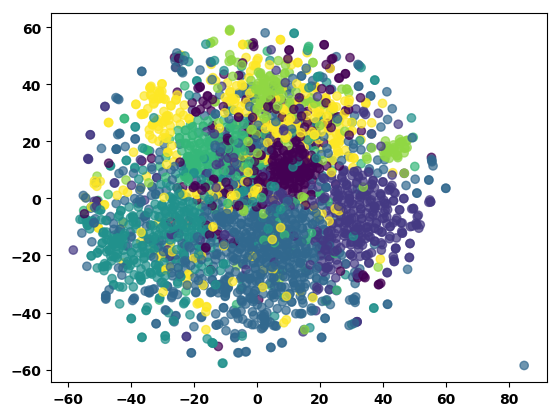

In [343]:
plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1], c=graph_labels, alpha=0.7,cmap='jet')
plt.show()

##  Reading labels form the loaded data

In [19]:
 graph_labels = th.LongTensor(graph_data.labels)

In [20]:
print(graph_labels)
print(graph_labels.shape)
print("\nThe graph has 7 lables for 2708 nodes\n")
print(graph_labels.unique())

tensor([2, 5, 4,  ..., 1, 0, 2])
torch.Size([2708])

The graph has 7 lables for 2708 nodes

tensor([2, 5, 4, 3, 6, 1, 0])


In [21]:
labels_numpy = graph_labels.numpy() 

In [22]:
print(np.unique(labels_numpy))

[0 1 2 3 4 5 6]


In [41]:
unique_label, label_count = numpy.unique(labels_numpy, return_counts=True)

In [44]:
unique_label

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [43]:
label_count

array([298, 418, 818, 426, 217, 180, 351], dtype=int64)

In [42]:
 dict(zip(unique_label, label_count))

{0: 298, 1: 418, 2: 818, 3: 426, 4: 217, 5: 180, 6: 351}

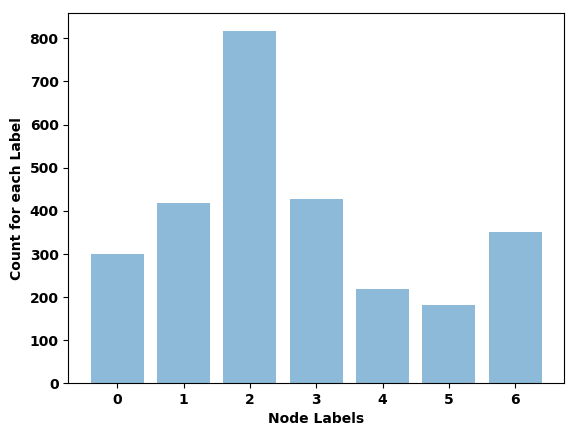

In [448]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

y_pos = np.arange(len(label_count))

plt.bar(y_pos, label_count, align='center', alpha=0.5)
plt.xticks(y_pos, unique_label)
plt.ylabel('Count for each Label')
plt.xlabel('Node Labels')
#plt.title('Count for each Label')

plt.show()

In [23]:
print("\nCount for each label in the graph\n")
np.bincount(labels_numpy)


Count for each label in the graph



array([298, 418, 818, 426, 217, 180, 351], dtype=int64)

## Masks on the labels

### train mask

In [24]:
 node_mask = th.ByteTensor(graph_data.train_mask)

In [25]:
print(node_mask)
print(node_mask.shape)

tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)
torch.Size([2708])


In [26]:
mask_numpy = node_mask.numpy() 

In [27]:
print(np.unique(node_mask))

[0 1]


In [577]:
np.bincount(node_mask)

array([2568,  140], dtype=int64)

###  Test Mask

In [68]:
 test_mask = th.ByteTensor(graph_data.test_mask)

In [69]:
print(test_mask)
print(test_mask.shape)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
torch.Size([2708])


In [70]:
mask_test_numpy = test_mask.numpy() 

In [73]:
print(np.unique(test_mask))

[0 1]


In [578]:
np.bincount(mask_test_numpy)

array([1708, 1000], dtype=int64)

In [76]:
unique, count = numpy.unique(mask_test_numpy, return_counts=True)

In [79]:
 dict(zip(unique, count))

{0: 1708, 1: 1000}

In [107]:
val_mask = th.ByteTensor(graph_data.val_mask)

In [109]:
val_mask.shape

torch.Size([2708])

In [110]:
print(np.unique(val_mask))

[0 1]


In [111]:
mask_val_numpy = val_mask.numpy() 

In [113]:
np.bincount(mask_val_numpy)

array([2408,  300], dtype=int64)

#  Visualizing the graph

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
nx_G = graph.to_networkx()

In [39]:
type(graph)

dgl.graph.DGLGraph

In [35]:
x=graph.adjacency_matrix

In [40]:
type(x)

method

In [30]:
pos = nx.kamada_kawai_layout(nx_G)

In [31]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (22,20)

Populating the interactive namespace from numpy and matplotlib


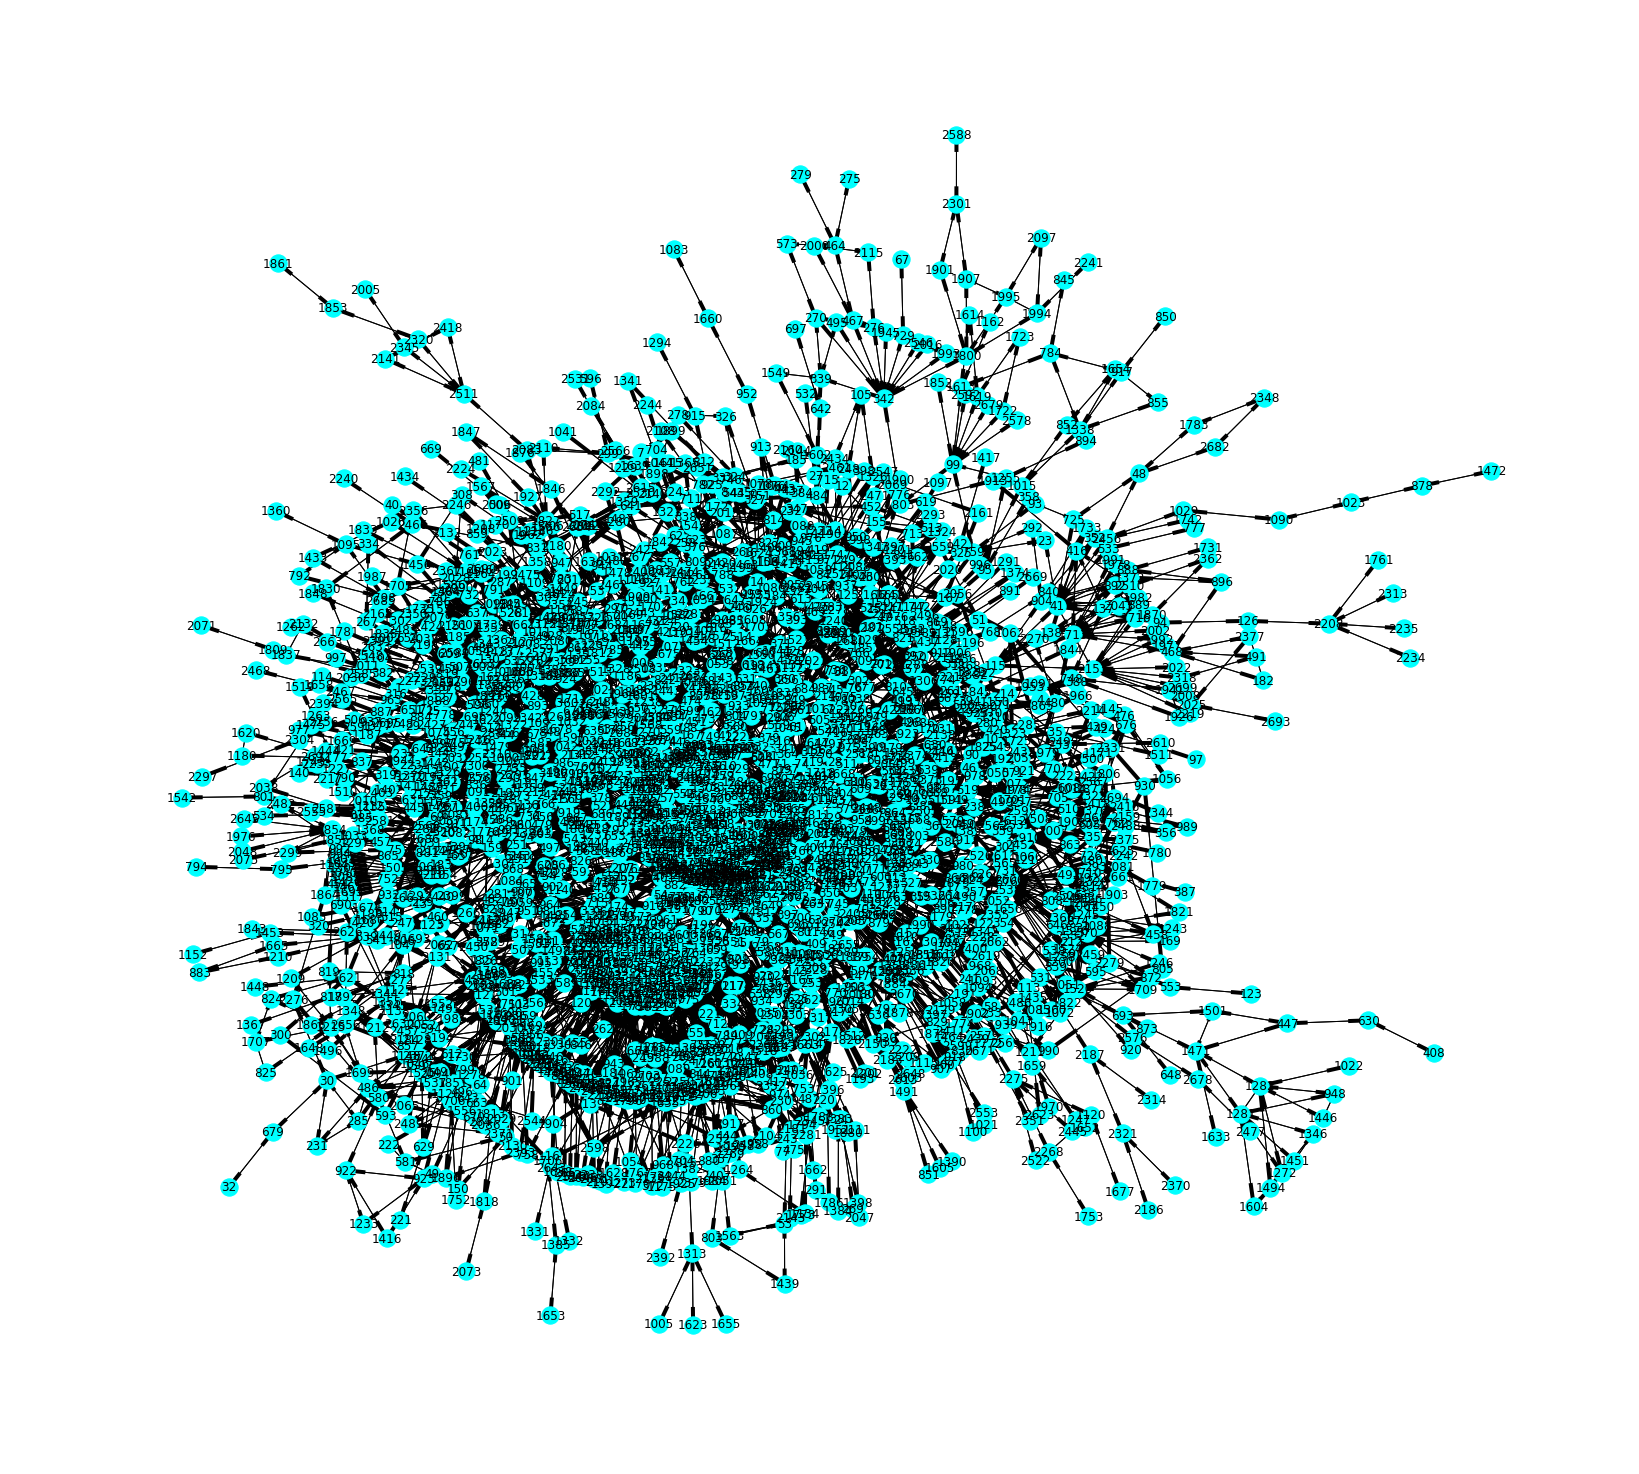

In [62]:
nx.draw(nx_G, pos, with_labels=True, node_color='#00FFFF')

In [ ]:
%pylab inline 

In [105]:
def visualize(labels, g):
    #pos = nx.spring_layout(g)
    plt.figure(figsize=(20,20))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=100, cmap=plt.get_cmap('coolwarm'),
                     node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)

In [109]:
pos = nx.kamada_kawai_layout(nx_G)

In [ ]:
visualize(graph_labels, nx_G)

In [118]:
graph_labels

tensor([2, 5, 4,  ..., 1, 0, 2])

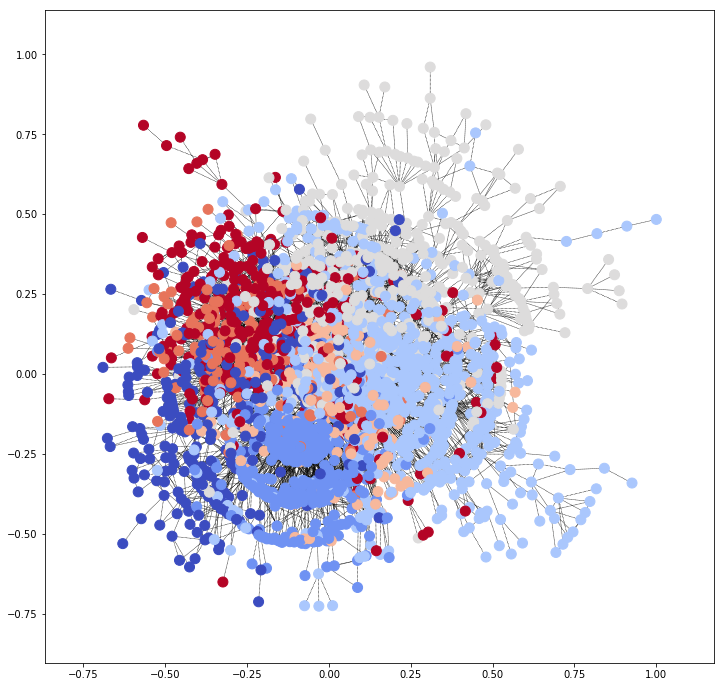

In [117]:
plt.figure(figsize=(12,12))
nx.draw_networkx(nx_G, pos=pos, node_size=100, cmap=plt.get_cmap('coolwarm'),
                     node_color=graph_labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)

# Training the Model

In [80]:
input_features = 1433
hidden1 = 32
hidden2 = 16

In [64]:
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


In [453]:
print(graph)
print(graph_features)
print(graph_features.shape)
print(graph_labels)
print(graph_labels.shape)
print(node_mask)
print(node_mask.shape)

DGLGraph(num_nodes=2708, num_edges=10556,
         ndata_schemes={}
         edata_schemes={})
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([2708, 1433])
tensor([2, 5, 4,  ..., 1, 0, 2])
torch.Size([2708])
tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)
torch.Size([2708])


In [532]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.gcn1 = GCN(input_size, hidden1, F.relu)
        self.gcn_drop1 = nn.Dropout(0.4)
        self.gcn2 = GCN(hidden1, hidden2, F.relu)
        self.gcn_drop2 = nn.Dropout(0.3)
        self.gcn3 = GCN(hidden2, output_size, F.relu)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = F.dropout(x, training=self.training)
        x = self.gcn2(g, x)
        x = F.dropout(x, training=self.training)
        x = self.gcn3(g, x)
        return x

In [533]:
network4 = Net1()
# network structure
print(network4)

Net1(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=32, bias=True)
    )
  )
  (gcn_drop1): Dropout(p=0.4)
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (gcn_drop2): Dropout(p=0.3)
  (gcn3): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


In [534]:
# Train the model
import time
import numpy as np
g, features, labels, mask = load_cora_data()
optimizer8 = th.optim.Adam(network4.parameters(), lr=1e-3)
dur = []
for epoch in range(1500):
    if epoch >=3:
        t0 = time.time()
    # Run the forward pass
    logits8 = network4(g, features)
    logp8 = F.log_softmax(logits8, 1)
    loss8 = F.nll_loss(logp8[node_mask], labels[mask])
    
    _, pred8 = th.max(logits.data, -1)
    
    # Backprop and perform Adam optimisation
    optimizer8.zero_grad()
    loss8.backward()
    optimizer8.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            epoch, loss8.item(), np.mean(dur)))
    print("Predict lables for labelled the Nodes in the graph:\n")
    print(pred8[mask])

C:\Users\Administrator\Anaconda3\lib\site-packages\dgl\base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 1.9282 | Time(s) nan
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00001 | Loss 1.8681 | Time(s) nan
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3,

Epoch 00015 | Loss 1.6038 | Time(s) 0.5006
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00016 | Loss 1.5352 | Time(s) 0.4971
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00030 | Loss 1.2630 | Time(s) 0.4802
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00031 | Loss 1.2830 | Time(s) 0.4803
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00045 | Loss 1.1265 | Time(s) 0.4902
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00046 | Loss 1.2128 | Time(s) 0.4916
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00060 | Loss 1.0461 | Time(s) 0.4885
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00061 | Loss 1.0883 | Time(s) 0.4883
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00075 | Loss 0.9313 | Time(s) 0.5569
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00076 | Loss 0.9295 | Time(s) 0.5708
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00090 | Loss 0.8763 | Time(s) 0.6652
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00091 | Loss 0.8826 | Time(s) 0.6648
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00105 | Loss 0.8461 | Time(s) 0.7682
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00106 | Loss 0.8414 | Time(s) 0.7729
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00120 | Loss 0.8278 | Time(s) 0.8630
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00121 | Loss 0.7985 | Time(s) 0.8687
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00135 | Loss 0.8074 | Time(s) 0.9012
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00136 | Loss 0.8708 | Time(s) 0.9071
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00150 | Loss 0.7836 | Time(s) 0.9337
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00151 | Loss 0.7780 | Time(s) 0.9316
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00165 | Loss 0.7170 | Time(s) 0.9192
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00166 | Loss 0.7274 | Time(s) 0.9230
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00180 | Loss 0.7232 | Time(s) 0.9645
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00181 | Loss 0.7036 | Time(s) 0.9628
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00195 | Loss 0.6917 | Time(s) 0.9306
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00196 | Loss 0.7277 | Time(s) 0.9281
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00210 | Loss 0.6690 | Time(s) 0.9259
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00211 | Loss 0.6517 | Time(s) 0.9254
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00225 | Loss 0.5197 | Time(s) 0.9596
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00226 | Loss 0.6233 | Time(s) 0.9602
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00240 | Loss 0.5967 | Time(s) 0.9852
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00241 | Loss 0.5236 | Time(s) 0.9881
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00255 | Loss 0.4263 | Time(s) 1.0131
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00256 | Loss 0.5117 | Time(s) 1.0125
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00270 | Loss 0.4539 | Time(s) 1.0237
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00271 | Loss 0.4670 | Time(s) 1.0219
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00285 | Loss 0.4875 | Time(s) 1.0380
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00286 | Loss 0.4460 | Time(s) 1.0372
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00300 | Loss 0.4176 | Time(s) 1.0538
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00301 | Loss 0.4096 | Time(s) 1.0561
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00315 | Loss 0.3947 | Time(s) 1.0790
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00316 | Loss 0.4462 | Time(s) 1.0796
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00330 | Loss 0.3689 | Time(s) 1.0825
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00331 | Loss 0.4027 | Time(s) 1.0814
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00345 | Loss 0.3679 | Time(s) 1.0585
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00346 | Loss 0.3904 | Time(s) 1.0571
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00360 | Loss 0.3844 | Time(s) 1.0627
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00361 | Loss 0.3502 | Time(s) 1.0641
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00375 | Loss 0.3756 | Time(s) 1.0824
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00376 | Loss 0.3662 | Time(s) 1.0836
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00390 | Loss 0.3407 | Time(s) 1.0788
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00391 | Loss 0.3546 | Time(s) 1.0802
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00405 | Loss 0.3647 | Time(s) 1.0660
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00406 | Loss 0.3569 | Time(s) 1.0646
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00420 | Loss 0.3257 | Time(s) 1.0445
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00421 | Loss 0.3281 | Time(s) 1.0431
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00435 | Loss 0.3718 | Time(s) 1.0244
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00436 | Loss 0.3694 | Time(s) 1.0231
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00450 | Loss 0.3735 | Time(s) 1.0056
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00451 | Loss 0.3401 | Time(s) 1.0045
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00465 | Loss 0.3619 | Time(s) 0.9911
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00466 | Loss 0.3165 | Time(s) 0.9900
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00480 | Loss 0.3332 | Time(s) 0.9764
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00481 | Loss 0.3417 | Time(s) 0.9754
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00495 | Loss 0.3292 | Time(s) 0.9621
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00496 | Loss 0.3226 | Time(s) 0.9613
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00510 | Loss 0.3378 | Time(s) 0.9623
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00511 | Loss 0.3596 | Time(s) 0.9615
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00525 | Loss 0.2959 | Time(s) 0.9515
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00526 | Loss 0.3300 | Time(s) 0.9506
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00540 | Loss 0.3053 | Time(s) 0.9398
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00541 | Loss 0.3160 | Time(s) 0.9390
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00555 | Loss 0.3204 | Time(s) 0.9423
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00556 | Loss 0.3109 | Time(s) 0.9427
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00570 | Loss 0.2826 | Time(s) 0.9343
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00571 | Loss 0.3140 | Time(s) 0.9336
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00585 | Loss 0.3116 | Time(s) 0.9229
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00586 | Loss 0.3077 | Time(s) 0.9221
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00600 | Loss 0.3029 | Time(s) 0.9299
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00601 | Loss 0.2958 | Time(s) 0.9309
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00615 | Loss 0.3103 | Time(s) 0.9422
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00616 | Loss 0.3023 | Time(s) 0.9432
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00630 | Loss 0.2902 | Time(s) 0.9502
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00631 | Loss 0.2761 | Time(s) 0.9508
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00645 | Loss 0.3378 | Time(s) 0.9569
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00646 | Loss 0.2906 | Time(s) 0.9563
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00660 | Loss 0.3009 | Time(s) 0.9517
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00661 | Loss 0.3167 | Time(s) 0.9526
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00675 | Loss 0.2822 | Time(s) 0.9605
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00676 | Loss 0.2870 | Time(s) 0.9599
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00690 | Loss 0.3090 | Time(s) 0.9604
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00691 | Loss 0.2977 | Time(s) 0.9613
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00705 | Loss 0.3210 | Time(s) 0.9702
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00706 | Loss 0.2845 | Time(s) 0.9702
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00720 | Loss 0.2745 | Time(s) 0.9773
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00721 | Loss 0.2704 | Time(s) 0.9779
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00735 | Loss 0.2963 | Time(s) 0.9844
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00736 | Loss 0.2784 | Time(s) 0.9852
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00750 | Loss 0.2690 | Time(s) 0.9841
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00751 | Loss 0.2562 | Time(s) 0.9835
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00765 | Loss 0.2610 | Time(s) 0.9764
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00766 | Loss 0.2571 | Time(s) 0.9758
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00780 | Loss 0.2664 | Time(s) 0.9669
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00781 | Loss 0.2932 | Time(s) 0.9664
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00795 | Loss 0.3108 | Time(s) 0.9583
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00796 | Loss 0.2688 | Time(s) 0.9577
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00810 | Loss 0.2763 | Time(s) 0.9496
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00811 | Loss 0.2963 | Time(s) 0.9490
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00825 | Loss 0.2806 | Time(s) 0.9414
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00826 | Loss 0.2702 | Time(s) 0.9408
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00840 | Loss 0.2573 | Time(s) 0.9332
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00841 | Loss 0.2755 | Time(s) 0.9327
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00855 | Loss 0.2754 | Time(s) 0.9251
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00856 | Loss 0.2532 | Time(s) 0.9246
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00870 | Loss 0.2818 | Time(s) 0.9171
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00871 | Loss 0.2854 | Time(s) 0.9166
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00885 | Loss 0.2632 | Time(s) 0.9106
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00886 | Loss 0.2637 | Time(s) 0.9102
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00900 | Loss 0.2463 | Time(s) 0.9038
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00901 | Loss 0.2607 | Time(s) 0.9033
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00915 | Loss 0.2769 | Time(s) 0.8971
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00916 | Loss 0.2656 | Time(s) 0.8966
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00930 | Loss 0.2654 | Time(s) 0.8902
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00931 | Loss 0.2394 | Time(s) 0.8898
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00945 | Loss 0.2643 | Time(s) 0.8838
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00946 | Loss 0.2499 | Time(s) 0.8834
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00960 | Loss 0.2593 | Time(s) 0.8779
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00961 | Loss 0.2769 | Time(s) 0.8775
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00975 | Loss 0.2581 | Time(s) 0.8719
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00976 | Loss 0.2594 | Time(s) 0.8716
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 00990 | Loss 0.2526 | Time(s) 0.8664
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 00991 | Loss 0.2728 | Time(s) 0.8660
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01005 | Loss 0.2628 | Time(s) 0.8607
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01006 | Loss 0.2643 | Time(s) 0.8604
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01020 | Loss 0.2372 | Time(s) 0.8552
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01021 | Loss 0.2428 | Time(s) 0.8548
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01035 | Loss 0.2824 | Time(s) 0.8602
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01036 | Loss 0.2730 | Time(s) 0.8601
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01050 | Loss 0.2411 | Time(s) 0.8643
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01051 | Loss 0.2386 | Time(s) 0.8645
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01065 | Loss 0.2378 | Time(s) 0.8683
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01066 | Loss 0.2593 | Time(s) 0.8689
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01080 | Loss 0.2524 | Time(s) 0.8763
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01081 | Loss 0.2490 | Time(s) 0.8766
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01095 | Loss 0.2448 | Time(s) 0.8830
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01096 | Loss 0.2379 | Time(s) 0.8837
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01110 | Loss 0.2367 | Time(s) 0.8829
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01111 | Loss 0.2698 | Time(s) 0.8826
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01125 | Loss 0.2439 | Time(s) 0.8777
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01126 | Loss 0.2475 | Time(s) 0.8773
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01140 | Loss 0.2643 | Time(s) 0.8769
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01141 | Loss 0.2729 | Time(s) 0.8773
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01155 | Loss 0.2372 | Time(s) 0.8761
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01156 | Loss 0.2372 | Time(s) 0.8758
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01170 | Loss 0.2522 | Time(s) 0.8718
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01171 | Loss 0.2543 | Time(s) 0.8716
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01185 | Loss 0.2365 | Time(s) 0.8779
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01186 | Loss 0.2413 | Time(s) 0.8784
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01200 | Loss 0.2397 | Time(s) 0.8855
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01201 | Loss 0.2652 | Time(s) 0.8860
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01215 | Loss 0.2402 | Time(s) 0.8911
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01216 | Loss 0.2434 | Time(s) 0.8920
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01230 | Loss 0.2307 | Time(s) 0.8931
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01231 | Loss 0.2419 | Time(s) 0.8937
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01245 | Loss 0.2391 | Time(s) 0.9012
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01246 | Loss 0.2481 | Time(s) 0.9016
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01260 | Loss 0.2529 | Time(s) 0.9086
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01261 | Loss 0.2462 | Time(s) 0.9092
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01275 | Loss 0.2449 | Time(s) 0.9140
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01276 | Loss 0.2415 | Time(s) 0.9144
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01290 | Loss 0.2407 | Time(s) 0.9184
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01291 | Loss 0.2453 | Time(s) 0.9189
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01305 | Loss 0.2467 | Time(s) 0.9246
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01306 | Loss 0.2606 | Time(s) 0.9246
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01320 | Loss 0.2394 | Time(s) 0.9205
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01321 | Loss 0.2404 | Time(s) 0.9202
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01335 | Loss 0.2618 | Time(s) 0.9191
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01336 | Loss 0.2263 | Time(s) 0.9195
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01350 | Loss 0.2453 | Time(s) 0.9253
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01351 | Loss 0.2313 | Time(s) 0.9255
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01365 | Loss 0.2375 | Time(s) 0.9273
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01366 | Loss 0.2469 | Time(s) 0.9272
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01380 | Loss 0.2529 | Time(s) 0.9262
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01381 | Loss 0.2506 | Time(s) 0.9259
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01395 | Loss 0.2516 | Time(s) 0.9223
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01396 | Loss 0.2799 | Time(s) 0.9220
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01410 | Loss 0.2854 | Time(s) 0.9177
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01411 | Loss 0.2452 | Time(s) 0.9174
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01425 | Loss 0.2495 | Time(s) 0.9132
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01426 | Loss 0.2596 | Time(s) 0.9129
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01440 | Loss 0.2408 | Time(s) 0.9087
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01441 | Loss 0.2406 | Time(s) 0.9084
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01455 | Loss 0.2459 | Time(s) 0.9043
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01456 | Loss 0.2548 | Time(s) 0.9040
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01470 | Loss 0.2373 | Time(s) 0.9005
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01471 | Loss 0.2346 | Time(s) 0.9003
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

Epoch 01485 | Loss 0.2533 | Time(s) 0.8991
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])
Epoch 01486 | Loss 0.2424 | Time(s) 0.8988
Predict lables for labelled the Nodes in the graph:

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3,

In [535]:
print("Predicted Labels\n")
print(pred8[node_mask])
print("\n")
print("Actual Labels\n")
print(graph_labels[node_mask])


Predicted Labels

tensor([6, 0, 4, 4, 3, 3, 4, 0, 6, 4, 6, 1, 3, 0, 6, 1, 4, 0, 6, 3, 3, 4, 1, 3,
        4, 6, 6, 3, 6, 0, 0, 3, 0, 3, 4, 4, 3, 1, 1, 4, 0, 3, 1, 6, 0, 4, 0, 0,
        3, 0, 0, 3, 0, 1, 4, 1, 4, 4, 3, 3, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 3, 3,
        6, 4, 3, 0, 3, 0, 3, 0, 1, 0, 4, 4, 3, 4, 4, 0, 1, 6, 0, 4, 4, 3, 3, 3,
        0, 0, 4, 3, 1, 3, 6, 4, 6, 3, 0, 3, 3, 6, 6, 0, 1, 4, 0, 3, 0, 3, 4, 0,
        1, 3, 6, 0, 6, 3, 3, 6, 4, 1, 6, 3, 4, 6, 4, 0, 6, 3, 3, 1])


Actual Labels

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])


In [536]:
print("Predicted Labels\n")
print(pred8[test_mask])
print("\n")
print("Actual Labels\n")
print(graph_labels[test_mask])

Predicted Labels

tensor([1, 1, 4, 1, 0, 3, 0, 0, 1, 3, 3, 3, 1, 3, 4, 3, 0, 3, 3, 6, 0, 6, 3, 4,
        3, 3, 4, 4, 0, 3, 1, 3, 3, 3, 0, 6, 1, 1, 1, 0, 0, 0, 6, 0, 4, 4, 1, 3,
        4, 6, 0, 0, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 4, 1, 4, 4, 4, 4, 0, 4, 4, 4,
        4, 3, 3, 4, 4, 3, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 4, 4, 0, 4, 4, 0, 0, 4,
        0, 0, 0, 4, 6, 4, 1, 0, 3, 3, 1, 0, 3, 4, 4, 3, 0, 0, 0, 3, 0, 0, 0, 3,
        4, 4, 3, 3, 1, 1, 0, 0, 4, 0, 3, 0, 3, 4, 0, 0, 4, 3, 4, 3, 4, 3, 3, 0,
        4, 3, 3, 0, 0, 0, 4, 0, 0, 4, 0, 4, 4, 0, 1, 1, 0, 3, 3, 0, 3, 4, 0, 3,
        3, 0, 0, 4, 4, 0, 1, 0, 3, 3, 0, 0, 3, 1, 0, 0, 3, 4, 0, 6, 4, 1, 0, 4,
        0, 3, 3, 4, 4, 3, 1, 4, 4, 0, 0, 4, 3, 3, 4, 0, 3, 3, 0, 0, 1, 3, 1, 3,
        3, 1, 4, 6, 0, 1, 0, 4, 4, 3, 3, 1, 1, 3, 4, 3, 6, 4, 4, 3, 3, 4, 4, 4,
        3, 6, 3, 1, 1, 3, 4, 3, 3, 4, 0, 6, 0, 4, 0, 1, 0, 1, 1, 3, 0, 3, 0, 4,
        4, 1, 3, 0, 3, 1, 3, 6, 3, 4, 4, 4, 3, 3, 4, 6, 1, 1, 3, 0, 3, 0, 0, 3,
        3, 1, 0, 4, 0,

In [537]:
acc = evaluate(network4, g, features, labels, mask) 
print("Train Accuracy {:.4f}".format(acc))

Train Accuracy 0.8929


In [574]:
acc = evaluate(network4, g, features, graph_labels, val_mask) 
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.7300


In [539]:
acc = evaluate(network4, g, features, labels, test_mask) 
print("Train Accuracy {:.4f}".format(acc))

Train Accuracy 0.6520


##  Training -using 1 dropout layer + 3 GCN layers

In [484]:
network2 = Net()
print(network2)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=32, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (gcn_drop): Dropout(p=0.3)
  (gcn3): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


In [483]:
from dgl.data import citation_graph as citegrh
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = data.graph
    # add self loop
    g.remove_edges_from(g.selfloop_edges())
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask

In [485]:
import time
import numpy as np
g1, features1, labels, mask = load_cora_data()
optimizer7 = th.optim.Adam(network2.parameters(), lr=1e-3)
dur = []
all_logits = []

for epoch in range(1000):
    if epoch >=3:
        t0 = time.time()

    y_predict = network2(g1, features1)
    
    # Saved for visualizations
    all_logits.append(y_predict.detach())
    log_predict = F.log_softmax(y_predict, 1)
    
    _, pred = th.max(y_predict.data, -1)
    
    loss = F.nll_loss(log_predict[mask], labels[mask])
    

    optimizer7.zero_grad()
    loss.backward()
    optimizer7.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), np.mean(dur)))
    print("Predicted lables for the labeled Nodes:\n")
    print(pred[mask])

C:\Users\Administrator\Anaconda3\lib\site-packages\dgl\base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 1.9375 | Time(s) nan
Predicted lables for the labeled Nodes:

tensor([2, 5, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5,
        3, 5, 2, 5, 2, 5, 0, 5, 5, 5, 3, 3, 2, 2, 5, 5, 5, 2, 5, 2, 2, 5, 2, 5,
        2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 0, 2, 5, 5, 5, 2, 5, 5, 2, 5, 5, 5, 5, 5,
        2, 2, 2, 5, 5, 3, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 3, 2, 5, 5, 5, 5,
        2, 5, 5, 5, 5, 5, 5, 5, 2, 5, 3, 2, 2, 5, 2, 2, 2, 2, 3, 5, 2, 5, 5, 5,
        2, 5, 5, 5, 2, 5, 5, 2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 2])
Epoch 00001 | Loss 1.9382 | Time(s) nan
Predicted lables for the labeled Nodes:

tensor([2, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 2, 2, 5, 5, 5, 5, 2, 5, 5, 5,
        3, 0, 5, 5, 2, 2, 0, 5, 5, 2, 5, 3, 2, 5, 2, 3, 5, 2, 5, 5, 2, 5, 2, 0,
        0, 0, 2, 2, 2, 5, 5, 5, 0, 5, 5, 2, 5, 3, 2, 3, 5, 5, 5, 3, 5, 5, 5, 5,
        5, 5, 2, 5, 5, 5, 2, 5, 5, 3, 3, 5, 2, 5, 2, 2, 5, 2, 3, 5, 5, 5, 5, 2,
        5, 5, 3, 2, 5, 2, 2, 5, 5, 2, 2, 2, 3, 2,

Epoch 00015 | Loss 1.3285 | Time(s) 1.5208
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 3, 2, 2, 2, 2, 3, 3, 0, 2, 2, 4, 2, 2, 3, 3, 4, 4, 3,
        5, 3, 2, 3, 2, 2, 3, 2, 3, 3, 4, 3, 2, 4, 3, 4, 3, 3, 4, 2, 3, 4, 2, 5,
        3, 0, 0, 3, 3, 0, 4, 4, 3, 4, 2, 2, 4, 3, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3,
        2, 0, 3, 0, 3, 5, 3, 3, 2, 0, 4, 2, 3, 4, 2, 2, 2, 3, 0, 2, 4, 3, 3, 3,
        0, 2, 3, 3, 3, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 0, 3, 3, 3, 3, 4, 3,
        3, 2, 2, 0, 2, 2, 3, 2, 4, 2, 3, 3, 5, 2, 3, 5, 2, 3, 3, 3])
Epoch 00016 | Loss 1.3288 | Time(s) 1.5248
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 3, 2, 2, 2, 2, 3, 3, 0, 2, 2, 4, 2, 2, 3, 3, 3, 4, 3,
        2, 3, 2, 3, 2, 5, 0, 2, 3, 2, 4, 4, 2, 3, 3, 3, 3, 3, 4, 2, 3, 4, 2, 2,
        3, 0, 2, 3, 4, 2, 4, 3, 3, 4, 2, 2, 4, 5, 3, 2, 0, 3, 3, 3, 2, 0, 3, 3,
        2, 2, 3, 0, 3, 5, 2, 0, 2, 3, 4, 2, 3, 4, 2, 2, 2, 5, 2, 2, 4, 3, 3, 3,
        3, 2, 3, 3, 0, 2, 2, 4, 2, 3, 2, 3,

Epoch 00030 | Loss 0.9698 | Time(s) 1.4246
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        2, 6, 2, 3, 2, 2, 0, 2, 0, 2, 4, 4, 2, 1, 1, 3, 5, 3, 1, 2, 3, 4, 2, 2,
        3, 3, 0, 3, 2, 3, 4, 1, 2, 4, 2, 2, 4, 5, 3, 2, 0, 1, 3, 3, 2, 0, 3, 2,
        2, 2, 3, 0, 3, 2, 2, 2, 2, 0, 4, 2, 3, 4, 2, 2, 3, 2, 3, 2, 4, 3, 3, 3,
        2, 2, 3, 3, 3, 2, 2, 4, 2, 3, 2, 3, 3, 6, 2, 3, 2, 2, 3, 3, 3, 3, 4, 0,
        1, 2, 2, 3, 2, 3, 3, 2, 4, 1, 6, 3, 3, 2, 2, 2, 5, 3, 3, 1])
Epoch 00031 | Loss 0.9771 | Time(s) 1.4102
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        2, 3, 2, 3, 2, 2, 0, 2, 5, 2, 4, 2, 2, 1, 1, 2, 0, 3, 1, 2, 2, 4, 2, 2,
        3, 0, 0, 3, 6, 3, 3, 1, 6, 4, 2, 2, 4, 3, 3, 2, 0, 1, 0, 3, 2, 3, 6, 3,
        2, 2, 3, 0, 3, 5, 2, 5, 2, 3, 4, 2, 3, 4, 2, 2, 6, 2, 2, 2, 4, 3, 3, 3,
        4, 2, 3, 3, 3, 2, 2, 4, 2, 3, 2, 3,

Epoch 00045 | Loss 0.7943 | Time(s) 1.3457
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 5, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        2, 6, 2, 3, 2, 2, 0, 2, 0, 3, 4, 1, 2, 1, 1, 4, 3, 3, 1, 2, 6, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 3, 4, 2, 3, 4, 2, 2, 6, 5, 3, 2, 4, 3, 3, 3,
        6, 2, 3, 3, 2, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 3, 3, 6, 3, 4, 6,
        1, 2, 2, 3, 2, 2, 3, 2, 4, 1, 3, 3, 1, 2, 4, 1, 5, 3, 3, 1])
Epoch 00046 | Loss 0.7833 | Time(s) 1.3504
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 0, 2, 5, 3, 5, 2, 2, 6, 2, 2, 2, 6, 4, 1, 3,
        2, 6, 2, 3, 2, 0, 0, 2, 3, 2, 4, 4, 2, 1, 1, 4, 0, 3, 1, 2, 6, 4, 2, 2,
        3, 0, 0, 3, 5, 1, 6, 1, 6, 4, 2, 2, 4, 3, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 2, 4, 2, 3, 4, 5, 2, 6, 2, 2, 2, 4, 3, 3, 3,
        5, 3, 6, 3, 3, 2, 2, 4, 2, 3, 0, 3,

Epoch 00060 | Loss 0.6858 | Time(s) 1.3603
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        5, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 2, 2, 0, 1, 6, 0, 3, 1, 2, 0, 4, 2, 2,
        3, 0, 0, 3, 0, 1, 6, 1, 5, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 3, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 3, 2, 2, 4, 2, 3, 2, 3, 3, 6, 2, 0, 2, 2, 3, 3, 0, 3, 4, 0,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 0, 2, 6, 5, 5, 3, 3, 3])
Epoch 00061 | Loss 0.6551 | Time(s) 1.3583
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 0, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 2, 0, 3, 0, 2, 4, 3, 2, 0, 6, 4, 0, 3, 1, 2, 6, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 0, 4, 2, 2, 4, 0, 3, 6, 0, 1, 0, 1, 2, 3, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 3, 2, 0, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        6, 2, 6, 3, 6, 2, 2, 4, 2, 3, 5, 3,

Epoch 00075 | Loss 0.6004 | Time(s) 1.3587
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 0, 0, 2, 3, 2, 4, 4, 2, 1, 1, 4, 3, 3, 1, 2, 0, 4, 2, 2,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 3, 3, 4, 0, 3, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        6, 2, 6, 3, 1, 2, 2, 4, 2, 3, 2, 3, 3, 6, 2, 2, 2, 2, 0, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 4, 3, 1, 2, 2, 0, 5, 3, 3, 1])
Epoch 00076 | Loss 0.5405 | Time(s) 1.3549
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 6, 1, 4, 3, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 3, 4, 2, 3, 4, 5, 2, 6, 5, 2, 2, 4, 3, 3, 3,
        6, 2, 6, 3, 1, 2, 2, 4, 2, 3, 2, 3,

Epoch 00090 | Loss 0.5176 | Time(s) 1.3708
Predicted lables for the labeled Nodes:

tensor([2, 4, 4, 4, 3, 3, 4, 2, 2, 4, 2, 1, 3, 0, 2, 2, 4, 0, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 3, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 5, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 3, 4, 4, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 2, 3, 0, 3, 4, 0,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 3, 2, 2, 5, 5, 3, 3, 1])
Epoch 00091 | Loss 0.5260 | Time(s) 1.3712
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 0, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 2, 0, 2, 0, 4, 2, 3, 4, 5, 0, 6, 5, 0, 2, 4, 3, 3, 3,
        6, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00105 | Loss 0.4434 | Time(s) 1.3866
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 2, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 6, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 1, 2, 2, 5, 5, 3, 3, 1])
Epoch 00106 | Loss 0.4778 | Time(s) 1.3889
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 2, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 3, 1, 6, 4, 2, 2, 4, 0, 3, 4, 3, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 3, 2, 2, 4, 2, 3, 2, 3,

Epoch 00120 | Loss 0.4152 | Time(s) 1.3711
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 3, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 5, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 2, 6, 2, 2, 2, 2, 5, 3, 0, 3, 4, 1,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 3, 2, 2, 5, 5, 3, 3, 1])
Epoch 00121 | Loss 0.4433 | Time(s) 1.3639
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 0, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 0, 1, 4, 3, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 0, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 0, 3,
        2, 2, 2, 0, 3, 0, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 4, 3, 1, 2, 2, 4, 2, 3, 2, 3,

Epoch 00135 | Loss 0.3526 | Time(s) 1.2785
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 6, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 2, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 1, 2, 6, 5, 5, 3, 3, 1])
Epoch 00136 | Loss 0.3864 | Time(s) 1.2739
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 0, 1, 6, 1, 6, 4, 2, 2, 4, 3, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00150 | Loss 0.3292 | Time(s) 1.2058
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 6, 4, 2, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 0,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00151 | Loss 0.3398 | Time(s) 1.2012
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 3, 2, 5,
        3, 0, 0, 3, 5, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 6, 2, 2, 4, 2, 3, 5, 3,

Epoch 00165 | Loss 0.3297 | Time(s) 1.1416
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 3, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 0, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00166 | Loss 0.3382 | Time(s) 1.1374
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 3, 0, 3, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00180 | Loss 0.3699 | Time(s) 1.1238
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 3, 0, 3, 4, 4, 2, 6, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        6, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 3, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 6, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00181 | Loss 0.3512 | Time(s) 1.1278
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        3, 6, 2, 3, 2, 5, 0, 3, 0, 2, 6, 2, 2, 1, 1, 4, 6, 3, 1, 2, 0, 3, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00195 | Loss 0.2853 | Time(s) 1.1427
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 3, 2, 4, 6, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00196 | Loss 0.2986 | Time(s) 1.1408
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00210 | Loss 0.2961 | Time(s) 1.0966
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 1, 4, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 1, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00211 | Loss 0.3436 | Time(s) 1.0937
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 1, 2, 5, 0, 2, 0, 2, 4, 6, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        6, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00225 | Loss 0.2475 | Time(s) 1.0550
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 2, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 1, 2, 2, 5, 5, 3, 3, 1])
Epoch 00226 | Loss 0.2862 | Time(s) 1.0524
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 3, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 3, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00240 | Loss 0.2157 | Time(s) 1.0189
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 2, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 4, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00241 | Loss 0.2104 | Time(s) 1.0170
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 5, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 4, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00255 | Loss 0.2233 | Time(s) 1.0344
Predicted lables for the labeled Nodes:

tensor([2, 0, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 0, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00256 | Loss 0.1770 | Time(s) 1.0336
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 6, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00270 | Loss 0.1662 | Time(s) 1.0641
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 6, 2, 2, 5, 5, 3, 3, 1])
Epoch 00271 | Loss 0.1880 | Time(s) 1.0657
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 2, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 6,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00285 | Loss 0.1692 | Time(s) 1.0608
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 5, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 3, 2, 2, 5, 5, 1, 3, 1])
Epoch 00286 | Loss 0.1823 | Time(s) 1.0589
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 6, 0, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00300 | Loss 0.1815 | Time(s) 1.0365
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 5, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 6, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 3, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00301 | Loss 0.1357 | Time(s) 1.0349
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 3, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00315 | Loss 0.1663 | Time(s) 1.0117
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 3, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00316 | Loss 0.1780 | Time(s) 1.0099
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 3, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        1, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00330 | Loss 0.1470 | Time(s) 0.9874
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 4, 5, 5, 3, 3, 1])
Epoch 00331 | Loss 0.2384 | Time(s) 0.9858
Predicted lables for the labeled Nodes:

tensor([2, 2, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        4, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00345 | Loss 0.1720 | Time(s) 0.9707
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 6, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 1,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00346 | Loss 0.1774 | Time(s) 0.9696
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 3, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 0, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 6, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00360 | Loss 0.1290 | Time(s) 0.9653
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 5, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00361 | Loss 0.1413 | Time(s) 0.9662
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 1, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00375 | Loss 0.1352 | Time(s) 0.9825
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00376 | Loss 0.1469 | Time(s) 0.9834
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 6, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 0, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 1, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 0, 5, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00390 | Loss 0.2038 | Time(s) 0.9986
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 6, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 2, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 2, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00391 | Loss 0.1235 | Time(s) 0.9992
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00405 | Loss 0.1421 | Time(s) 1.0034
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 6, 3, 6, 5, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 2, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00406 | Loss 0.1512 | Time(s) 1.0020
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 2, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 5, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00420 | Loss 0.1119 | Time(s) 1.0054
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00421 | Loss 0.1298 | Time(s) 1.0069
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00435 | Loss 0.1312 | Time(s) 1.0208
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 4, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 0,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00436 | Loss 0.1141 | Time(s) 1.0212
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 6, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00450 | Loss 0.1127 | Time(s) 1.0315
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 6,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 0, 5, 3, 3, 1])
Epoch 00451 | Loss 0.1021 | Time(s) 1.0306
Predicted lables for the labeled Nodes:

tensor([2, 1, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 0, 3,

Epoch 00465 | Loss 0.1093 | Time(s) 1.0151
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 1,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 1, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 4, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00466 | Loss 0.0792 | Time(s) 1.0140
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00480 | Loss 0.1169 | Time(s) 0.9981
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 4, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 5])
Epoch 00481 | Loss 0.0859 | Time(s) 0.9970
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00495 | Loss 0.1248 | Time(s) 0.9824
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 3, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 1, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 0, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00496 | Loss 0.1436 | Time(s) 0.9817
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00510 | Loss 0.1337 | Time(s) 0.9933
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 3, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 1,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00511 | Loss 0.1424 | Time(s) 0.9943
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 3, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00525 | Loss 0.0703 | Time(s) 1.0082
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 0, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00526 | Loss 0.0726 | Time(s) 1.0094
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00540 | Loss 0.0896 | Time(s) 1.0073
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 4,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00541 | Loss 0.0989 | Time(s) 1.0063
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 6, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00555 | Loss 0.0687 | Time(s) 1.0146
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 4, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00556 | Loss 0.0856 | Time(s) 1.0151
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 3, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00570 | Loss 0.0953 | Time(s) 1.0256
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        4, 2, 6, 3, 1, 2, 2, 4, 2, 3, 0, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00571 | Loss 0.0945 | Time(s) 1.0266
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 5, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00585 | Loss 0.0682 | Time(s) 1.0330
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 3, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00586 | Loss 0.0825 | Time(s) 1.0333
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 6, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00600 | Loss 0.0933 | Time(s) 1.0416
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 5,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 5, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00601 | Loss 0.0708 | Time(s) 1.0425
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00615 | Loss 0.0958 | Time(s) 1.0492
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 0, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00616 | Loss 0.0734 | Time(s) 1.0495
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 4, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00630 | Loss 0.0484 | Time(s) 1.0579
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00631 | Loss 0.0878 | Time(s) 1.0588
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 4, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        4, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00645 | Loss 0.0671 | Time(s) 1.0515
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 3, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00646 | Loss 0.1060 | Time(s) 1.0508
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 5, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 2, 4, 2, 3, 4, 5, 5, 0, 5, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00660 | Loss 0.0563 | Time(s) 1.0396
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 3, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00661 | Loss 0.0878 | Time(s) 1.0391
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 4, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 1, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00675 | Loss 0.0713 | Time(s) 1.0280
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 0, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00676 | Loss 0.0735 | Time(s) 1.0272
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00690 | Loss 0.0855 | Time(s) 1.0160
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 5, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00691 | Loss 0.0568 | Time(s) 1.0152
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 3, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00705 | Loss 0.0639 | Time(s) 1.0228
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 3, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00706 | Loss 0.0740 | Time(s) 1.0237
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 3, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 3, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00720 | Loss 0.0999 | Time(s) 1.0267
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 4, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00721 | Loss 0.0755 | Time(s) 1.0260
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 2, 3,

Epoch 00735 | Loss 0.0446 | Time(s) 1.0291
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 0, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00736 | Loss 0.0745 | Time(s) 1.0299
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 2, 3,

Epoch 00750 | Loss 0.0464 | Time(s) 1.0335
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00751 | Loss 0.0554 | Time(s) 1.0328
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00765 | Loss 0.0574 | Time(s) 1.0229
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00766 | Loss 0.0540 | Time(s) 1.0222
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00780 | Loss 0.0410 | Time(s) 1.0125
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00781 | Loss 0.0614 | Time(s) 1.0118
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 3, 2, 2, 4, 0, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00795 | Loss 0.0441 | Time(s) 1.0026
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 1, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00796 | Loss 0.0507 | Time(s) 1.0035
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00810 | Loss 0.0379 | Time(s) 1.0101
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00811 | Loss 0.0590 | Time(s) 1.0100
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 4, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00825 | Loss 0.0590 | Time(s) 1.0137
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00826 | Loss 0.0507 | Time(s) 1.0142
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00840 | Loss 0.0815 | Time(s) 1.0223
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 4, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 4, 3, 3, 1])
Epoch 00841 | Loss 0.0429 | Time(s) 1.0229
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 3, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00855 | Loss 0.0717 | Time(s) 1.0270
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 3, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 6, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 4, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00856 | Loss 0.0791 | Time(s) 1.0264
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 3, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00870 | Loss 0.0960 | Time(s) 1.0262
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 3, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 4, 2, 6, 3, 0, 3, 4, 0,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00871 | Loss 0.0622 | Time(s) 1.0259
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 0, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 2, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00885 | Loss 0.0689 | Time(s) 1.0214
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00886 | Loss 0.0688 | Time(s) 1.0231
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00900 | Loss 0.0376 | Time(s) 1.0267
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00901 | Loss 0.0275 | Time(s) 1.0273
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00915 | Loss 0.0603 | Time(s) 1.0322
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 4, 0, 6, 3,
        2, 2, 3, 0, 3, 3, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 4, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00916 | Loss 0.0487 | Time(s) 1.0319
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00930 | Loss 0.0541 | Time(s) 1.0235
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 0, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 2, 2, 2, 5, 5, 3, 3, 1])
Epoch 00931 | Loss 0.0411 | Time(s) 1.0230
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 4, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00945 | Loss 0.0554 | Time(s) 1.0151
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 1, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 0, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00946 | Loss 0.0366 | Time(s) 1.0145
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00960 | Loss 0.0813 | Time(s) 1.0075
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 2, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 3, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 6, 3, 3, 1])
Epoch 00961 | Loss 0.0579 | Time(s) 1.0070
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00975 | Loss 0.0433 | Time(s) 1.0004
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])
Epoch 00976 | Loss 0.0593 | Time(s) 1.0000
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

Epoch 00990 | Loss 0.0444 | Time(s) 0.9949
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 4])
Epoch 00991 | Loss 0.0629 | Time(s) 0.9946
Predicted lables for the labeled Nodes:

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 3, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 1, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 2, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3,

In [151]:
log_predict.shape

torch.Size([2708, 7])

In [486]:
print(loss.item())
print(loss)

0.08231603354215622
tensor(0.0823, grad_fn=<NllLossBackward>)


In [164]:
graph_labels[node_mask]

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3, 1, 2, 2, 4, 2, 3, 5, 3, 3, 6, 2, 2, 2, 2, 6, 3, 0, 3, 4, 5,
        1, 2, 2, 2, 2, 2, 3, 2, 4, 1, 6, 3, 4, 2, 2, 5, 5, 3, 3, 1])

In [145]:
print(node_mask.shape)
print(type(node_mask))
node_mask

torch.Size([2708])
<class 'torch.Tensor'>


tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)

###  Evaluate Model

In [525]:
def evaluate(model,g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g,features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

###  Training set

In [526]:
acc = evaluate(network2, g1, graph_features, labels, mask) 
print("Train Accuracy {:.4f}".format(acc))

Train Accuracy 0.9929


In [502]:
# Metrics
from sklearn import metrics
score_acc = metrics.accuracy_score(graph_labels[node_mask], pred[node_mask])
print("Accuracy score: {}".format(score_acc))

score_nn_precision = metrics.precision_score(graph_labels[node_mask], pred[node_mask], average= "weighted")
print("Precision score: {}".format(score_nn_precision))

score_nn_recall = metrics.recall_score(graph_labels[node_mask], pred[node_mask], average= "weighted")
print("Recall score: {}".format(score_nn_recall))

score_nn_f1 = metrics.f1_score(graph_labels[node_mask], pred[node_mask], average= "weighted")
print("F1 score: {}".format(score_nn_f1))

Accuracy score: 0.9857142857142858
Precision score: 0.9862811791383219
Recall score: 0.9857142857142858
F1 score: 0.9856399726442965


In [440]:
from sklearn.metrics import confusion_matrix, classification_report

In [505]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [506]:
cm_nn_torch = confusion_matrix(graph_labels[node_mask], pred[node_mask])
print(cm_nn_torch)

[[13  0  0  0  0  0  1]
 [ 0 11  0  0  0  0  0]
 [ 0  0 41  0  0  0  0]
 [ 0  0  0 28  0  0  0]
 [ 0  0  1  0 20  0  0]
 [ 0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0 17]]


In [507]:
graph_labels.unique

<bound method Tensor.unique of tensor([2, 5, 4,  ..., 1, 0, 2])>

In [514]:
labels1 = graph_labels.numpy()

In [520]:
np.unique(labels1)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

Plotting confusion matrix


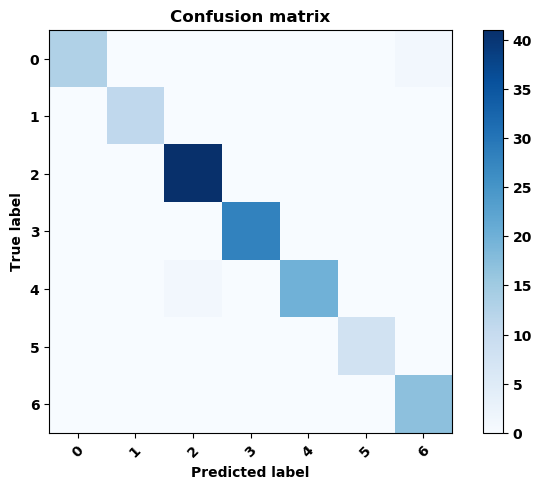

             precision    recall  f1-score   support

          0       1.00      0.93      0.96        14
          1       1.00      1.00      1.00        11
          2       0.98      1.00      0.99        41
          3       1.00      1.00      1.00        28
          4       1.00      0.95      0.98        21
          5       1.00      1.00      1.00         8
          6       0.94      1.00      0.97        17

avg / total       0.99      0.99      0.99       140



In [521]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_torch,np.unique(labels1))
plt.show()
print(classification_report(graph_labels[node_mask], pred[node_mask]))
# train set

### Test Set

In [575]:
graph_labels[val_mask]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 6, 1, 4, 3, 2, 4, 2, 0, 5, 2, 3, 1, 4, 0, 0, 5,
        5, 0, 2, 6, 1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 4, 1, 2, 6, 1, 2, 0, 3, 4,
        3, 5, 3, 6, 4, 2, 2, 6, 0, 2, 2, 0, 3, 2, 0, 2, 6, 1, 0, 6, 2, 2, 3, 2,
        2, 1, 4, 3, 3, 4, 3, 3, 3, 4, 2, 2, 0, 0, 5, 6, 0, 0, 1, 2, 3, 2, 4, 4,
        6, 2, 4, 6, 0, 2, 5, 0, 2, 4, 4, 5, 6, 1, 2, 2, 3, 0, 5, 2, 5, 6, 0, 6,
        2, 4, 6, 6, 3, 3, 3, 3, 2, 1, 2, 2, 3, 4, 6, 5, 2, 2, 2, 3, 2, 2, 3, 1,
        5, 3, 2, 3, 5, 2, 2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 4,
        2, 2, 4, 3, 1, 5, 4, 6, 3, 2, 6, 5, 1, 6, 6, 2, 2, 4, 2, 2, 2, 3, 1, 2,
        3, 2, 2, 1, 5, 2, 3, 2, 6, 3, 1, 1, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 0, 1,
        3, 5, 6, 3, 2, 6, 1, 3, 6, 4, 5, 2, 5, 3, 6, 6, 5, 5, 0, 2, 6, 2, 6, 2,
        4, 0, 3, 2, 2, 0, 4, 2, 1, 0, 3, 4, 3, 6, 0, 4, 6, 0, 2, 6, 4, 2, 2, 4,
        3, 4, 4, 3, 3, 2, 0, 4, 4, 4, 2, 1, 2, 4, 0, 0, 2, 6, 0, 4, 3, 3, 0, 2,
        6, 2, 4, 3, 4, 1, 2, 3, 2, 6, 3,

In [576]:
pred[val_mask]

tensor([2, 2, 2, 2, 2, 2, 2, 4, 6, 6, 4, 3, 2, 3, 6, 0, 5, 4, 6, 1, 4, 0, 0, 5,
        5, 0, 0, 6, 5, 2, 2, 0, 2, 2, 2, 2, 6, 1, 2, 4, 0, 2, 4, 1, 4, 0, 6, 4,
        3, 5, 2, 6, 2, 2, 2, 6, 6, 2, 2, 5, 3, 3, 1, 3, 6, 1, 1, 6, 2, 4, 3, 2,
        2, 1, 4, 3, 3, 4, 3, 3, 2, 0, 2, 4, 0, 0, 5, 6, 0, 0, 1, 2, 3, 2, 4, 4,
        6, 2, 4, 2, 0, 2, 5, 5, 2, 4, 4, 5, 6, 1, 2, 4, 3, 0, 5, 2, 5, 6, 5, 5,
        5, 4, 2, 6, 3, 3, 3, 3, 2, 4, 2, 2, 3, 4, 6, 5, 2, 2, 2, 3, 0, 0, 3, 4,
        5, 3, 2, 3, 6, 2, 2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 1, 4, 2, 6, 6, 0, 4,
        2, 2, 4, 6, 1, 5, 4, 6, 3, 3, 5, 0, 1, 6, 5, 6, 2, 4, 2, 2, 2, 3, 1, 2,
        3, 2, 2, 1, 6, 4, 3, 2, 2, 6, 1, 1, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 5, 1,
        3, 6, 5, 3, 2, 6, 1, 3, 2, 4, 5, 2, 5, 5, 6, 6, 5, 5, 5, 2, 6, 2, 6, 2,
        0, 6, 6, 2, 2, 5, 4, 5, 1, 6, 3, 4, 3, 6, 0, 4, 6, 0, 2, 6, 6, 2, 2, 4,
        3, 4, 4, 3, 3, 6, 6, 4, 4, 4, 6, 0, 2, 2, 6, 0, 2, 6, 0, 4, 3, 0, 0, 2,
        6, 2, 3, 3, 4, 2, 2, 3, 2, 6, 3,

In [570]:
 val_mask = th.ByteTensor(graph_data.val_mask)

In [571]:
acc = evaluate(network2, g1, graph_features, graph_labels, val_mask) 
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.7833


In [572]:
cm_nn_torch_val = confusion_matrix(graph_labels[val_mask], pred[val_mask])
print(cm_nn_torch_val)

[[17  2  0  0  0  6  6]
 [ 2 18  1  0  2  1  1]
 [ 4  0 82  3  8  2  6]
 [ 1  0  2 38  0  1  5]
 [ 2  0  2  2 31  0  1]
 [ 1  0  0  0  0 16  3]
 [ 0  0  4  0  1  4 25]]


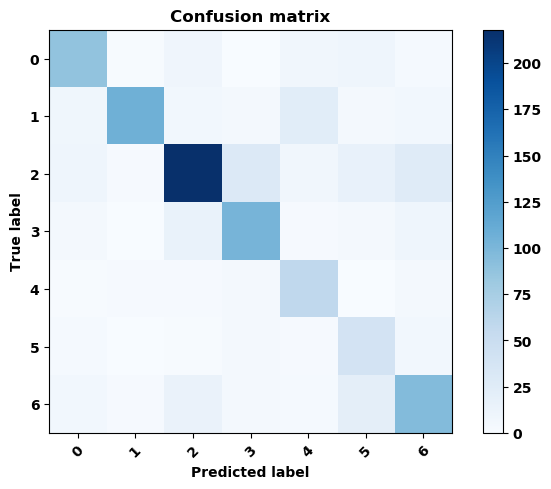

             precision    recall  f1-score   support

          0       0.63      0.55      0.59        31
          1       0.90      0.72      0.80        25
          2       0.90      0.78      0.84       105
          3       0.88      0.81      0.84        47
          4       0.74      0.82      0.78        38
          5       0.53      0.80      0.64        20
          6       0.53      0.74      0.62        34

avg / total       0.78      0.76      0.76       300



In [573]:
# print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_torch1,np.unique(labels1))
plt.show()
print(classification_report(graph_labels[val_mask], pred[val_mask]))
# Test Set

In [ ]:
acc = evaluate(network2, g1, graph_features, graph_labels, test_mask) 
print("Test Accuracy {:.4f}".format(acc))

In [503]:
acc = evaluate(network2, g1, graph_features, graph_labels, test_mask) 
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.7630


In [522]:
cm_nn_torch1 = confusion_matrix(graph_labels[test_mask], pred[test_mask])
print(cm_nn_torch1)

[[ 88   1   9   0   7  10   3]
 [  8 107   6   4  23   5   6]
 [ 10   2 218  29   7  17  26]
 [  4   0  15 103   2   4  10]
 [  1   2   2   4  58   0   5]
 [  3   0   1   5   2  40   6]
 [  6   2  14   5   3  21  96]]


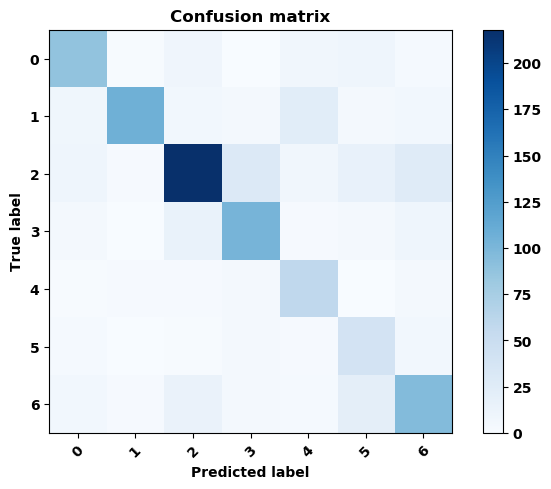

             precision    recall  f1-score   support

          0       0.73      0.75      0.74       118
          1       0.94      0.67      0.78       159
          2       0.82      0.71      0.76       309
          3       0.69      0.75      0.72       138
          4       0.57      0.81      0.67        72
          5       0.41      0.70      0.52        57
          6       0.63      0.65      0.64       147

avg / total       0.74      0.71      0.72      1000



In [541]:
# print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_torch1,np.unique(labels1))
plt.show()
print(classification_report(graph_labels[test_mask], pred[test_mask]))
# Test Set

# Visualize

In [542]:
pos1 = pos.copy()

In [550]:
i = 999
for v in range(2708):
    pos1[v] = all_logits[i][v].numpy()

In [376]:
print(pos[0])
print(pos1[1][1])
print(pos1[1])
print(pos1[2])
print(pos1[3])
print(pos1[4])

[0.04725215 0.45153588]
0.0
[0.07836151 0.         0.00178733 0.         0.         0.
 0.6534145 ]
[ 0.         0.         2.4285545  0.        13.776975   0.
  3.852556 ]
[0.         0.         0.42068908 0.         2.566437   0.
 0.44576636]
[0.2556543  0.08529457 0.1132981  0.         0.09364495 0.
 0.03762177]


In [553]:
len(all_logits)

1000

In [363]:
pos1[1]

array([0.17291859, 0.        , 0.04658195, 0.        , 0.        ,
       0.        , 0.86718506], dtype=float32)

In [266]:
all_logits[0][9]

tensor([0.0000, 0.0000, 0.1095, 0.0000, 0.2334, 0.0000, 2.9204])

In [551]:
pos2 = list(pos1.values())

## TNSE Dimensional reduction

In [552]:
transform = TSNE
trans2d = transform(n_components=2)

In [554]:
node_embeddings_2d_ = trans2d.fit_transform(pos2)

In [555]:
node_embeddings_2d_

array([[ 63.096363 ,  31.127174 ],
       [ 10.210993 ,  50.22844  ],
       [ 22.892683 , -55.873672 ],
       ...,
       [-47.16043  , -35.726627 ],
       [-58.219334 ,   9.467407 ],
       [  1.1056575,  34.84676  ]], dtype=float32)

*** Visualising graph for epoch 1000 ***

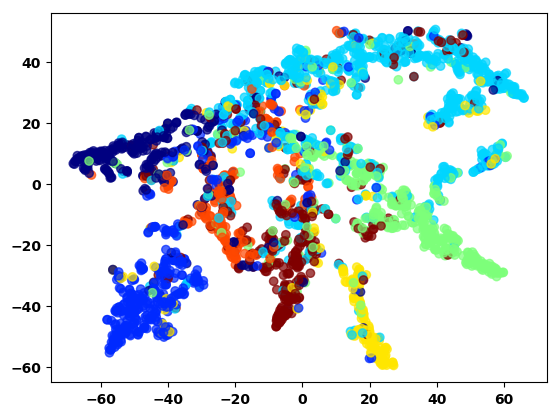

In [557]:
#plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d_[:,0], node_embeddings_2d_[:,1], c=graph_labels,cmap="jet", alpha=0.7)
plt.show()
# For epoch 999

*** 3D Visualization ***

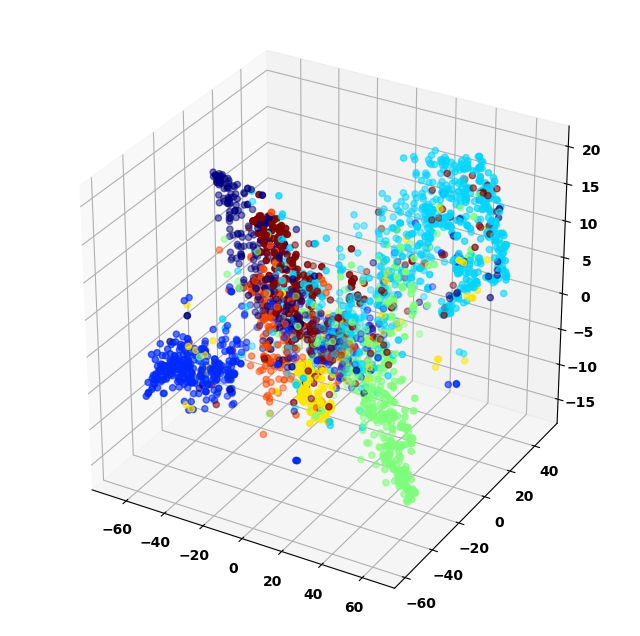

In [562]:
plt.figure(figsize=(8,8)) 
ax = plt.axes(projection='3d')
ax.scatter3D(node_embeddings_2d_[:,0], node_embeddings_2d_[:,1], node_embeddings_3d[:,2], c=graph_labels, cmap='jet');

*** Visualize with edges ***

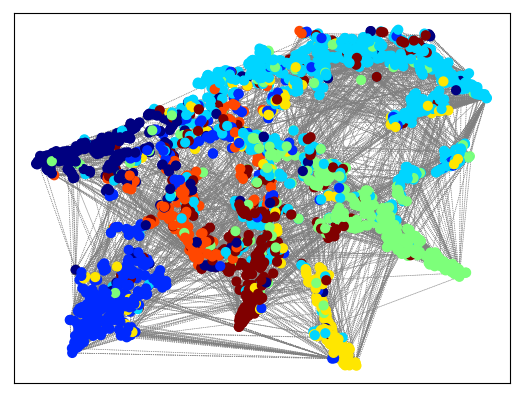

In [563]:
 nx.draw_networkx(nx_G, pos=node_embeddings_2d_, node_size=40, cmap='jet',
                     node_color=graph_labels, edge_color='grey', edge_cmap ='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)

*** We can also visualize for epoch 0 ***

In [564]:
i = 0
for v in range(2708):
    pos1[v] = all_logits[i][v].numpy()

In [565]:
pos0 = list(pos1.values())

In [566]:
node_embeddings_2d_0 = trans2d.fit_transform(pos0)

In [567]:
node_embeddings_2d_0

array([[-45.267612  , -15.7040615 ],
       [ 12.67685   , -14.409863  ],
       [-36.83373   ,  11.238091  ],
       ...,
       [ -0.18985966,  19.820433  ],
       [ -9.733121  , -16.623425  ],
       [ -5.5734024 ,  33.38603   ]], dtype=float32)

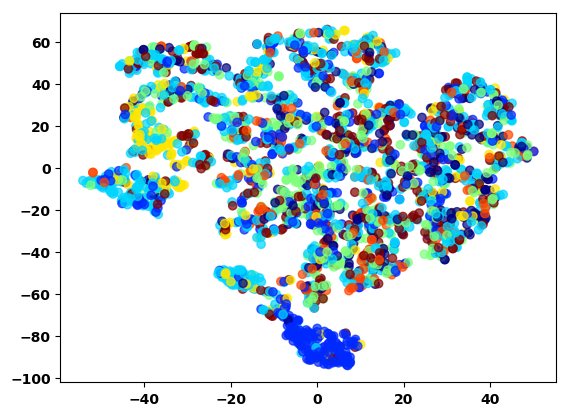

In [568]:
#plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d_0[:,0], node_embeddings_2d_0[:,1], c=graph_labels,cmap="jet", alpha=0.7)
plt.show()
# For epoch 999